# Layer setup plots

This notebook is used to create summary plots of F-layer input models
(i.e. temperature, pressure, and composition) of particular cases.
It relies on our `layer_setup` module.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

import flayer
import feo_thermodynamics as feot
import earth_model
import layer_setup

## Function to make the plots

This does all the setup normally used inside a calculation and just plots
the various temperature and composition functions as well as working out
the stability of the (liquid only) layer.

In [12]:
def make_layer_plot(dt, dx, xfe_outer_core, r_icb=1221.5E3, gruneisen_parameter=1.5, r_cmb=3480.0E3, 
                    f_layer_thickness=200_000, number_of_analysis_points=100,
                    number_of_knots=5, fig=None, ax=None):

    # Setup the f-layer

    # Derived radii
    r_flayer_top = r_icb + f_layer_thickness
         
    # Discretisation points
    nucleation_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
    analysis_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
    knott_radii = np.linspace(r_icb, r_flayer_top, number_of_knots)

    # Reuse general layer setup code, but we don't need many of the functions
    # so we never need to rerun this (fairly expensive) function
    _, adiabatic_temperature_function, _, _, _, pressure_function, gravity_function, _ = layer_setup.setup_flayer_functions(
        r_icb, r_cmb, f_layer_thickness, gruneisen_parameter, 10, xfe_outer_core, xfe_outer_core, knott_radii)
    
    temperature_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, adiabatic_temperature_function(r_icb)+dt, 
            adiabatic_temperature_function(r_flayer_top))
    composition_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, xfe_outer_core+dx, xfe_outer_core)
    Nbv, N2 = layer_setup.estimate_brunt_vaisala_frequency(
            r_flayer_top, r_icb, temperature_function, adiabatic_temperature_function,
            composition_function, gravity_function, pressure_function)

    print(f"BV freq = {Nbv}")
    rs = np.linspace(r_icb, r_flayer_top+100.0E3)

    # Check PREM works ... and print some interesting values
    prem = earth_model.Prem()
    print("Pressure at ICB:", prem.pressure(r_icb/1000.0), "GPa")
    print("Pressure at top of F-layer", prem.pressure(r_flayer_top/1000.0), "GPa")
    print("g at ICB:", prem.gravity(r_icb/1000.0), "m/s**2")
    print("g at top of F-layer", prem.gravity(r_flayer_top/1000.0), "m/s**2")

    # Find the liquidus
    @np.vectorize
    def full_temperature_function(r):
        if r < r_flayer_top:
            return temperature_function(r) 
        else:
            return adiabatic_temperature_function(r)
        
    @np.vectorize
    def full_composition_function(r):
        if r < r_flayer_top:
            return composition_function(r) 
        else:
            return xfe_outer_core 
    
    tl = feot.find_liquidus(full_composition_function(rs), pressure_function(rs))

    # Find the liquid density

    liquid_density, _, _, solid_density, _, _ = feot.densities(composition_function(rs), pressure_function(rs),
                                                           temperature_function(rs))

    # This is for a well mixed core extended down 
    adiabatic_liquid_density, _, _, adiabatic_solid_density, _, _ = feot.densities(xfe_outer_core, pressure_function(rs), 
                                                                               adiabatic_temperature_function(rs))
    
    print("Temperature at CMB:", full_temperature_function(r_cmb), "K")
    print("Liquid density at ICB:", liquid_density[0], "Kg/m^3")
    print("Liquid density at top of F-layer", liquid_density[-1], "Kg/m^3")
    print("Liquid density along adiabat at ICB:", adiabatic_liquid_density[0], "Kg/m^3")
    print("Liquid density along adiabat at top of F-layer", adiabatic_liquid_density[-1], "Kg/m^3")
    print("Liquid density difference at ICB:", liquid_density[0]-adiabatic_liquid_density[0], "Kg/m^3")

    # Plot the F-layer setup alongside the liquidus
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(6,6))
    ax_in = inset_axes(ax, width="35%", height="35%", loc=1, borderpad=1)
    
    color = 'tab:red'
    ax.set_xlabel('Radius (km)')
    ax.set_ylabel('Temperature (K)', color=color)
    ax.plot(rs/1000.0, full_temperature_function(rs), color=color)
    ax.plot(rs/1000.0, adiabatic_temperature_function(rs), color=color, ls='--')
    ax.plot(rs/1000.0, tl, color='k', ls=':')

    ax.tick_params(axis='y', labelcolor=color)
    ax.set_ylim([4940, 5140])
 

    #color = 'tab:blue'
    #ax2.set_xlabel('Radius (km)')
    #ax2.set_ylabel('Pressure (GPs)', color=color)  
    #ax2.plot(rs/1000.0, pressure_function(rs), color=color)
    #ax2.tick_params(axis='y', labelcolor=color)
    #ax2.set_ylim([310, 330])

    color = 'tab:green'
    ax_in.set_xlabel('Radius (km)')
    ax_in.set_ylabel('Composition (mol. frac. Fe)', color=color)  
    ax_in.plot(rs/1000.0, full_composition_function(rs), color=color)
    ax_in.plot(rs/1000.0, np.ones_like(rs)*xfe_outer_core, color=color, ls='--')
    ax_in.tick_params(axis='y', labelcolor=color)
    ax_in.set_ylim([0.828, 0.842])

    #ax4.set_xlabel('Radius (km)')
    #ax4.set_ylabel('Liquid density (kg/m^3)')  
    #ax4.plot(rs/1000.0, liquid_density)
    #ax4.plot(rs/1000.0, adiabatic_liquid_density, ls='--')
    #ax4.plot(rs/1000.0, solid_density, ls=':')
    #ax4.tick_params(axis='y')

    plt.show()

## Case 1

This (40 K hotter than the projected adiabat at the ICB and 1 mol % enriched in Fe) 
generates about 2.4 TW of heat and particles with a maximum radius of about 1.6 cm.

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


BV freq = 0.00022590837386311853
Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Liquid density at ICB: 12792.534318523183 Kg/m^3
Liquid density at top of F-layer 12542.509302676566 Kg/m^3
Liquid density along adiabat at ICB: 12764.931169768386 Kg/m^3
Liquid density along adiabat at top of F-layer 12571.912798104033 Kg/m^3
Liquid density difference at ICB: 27.603148754797076 Kg/m^3


/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


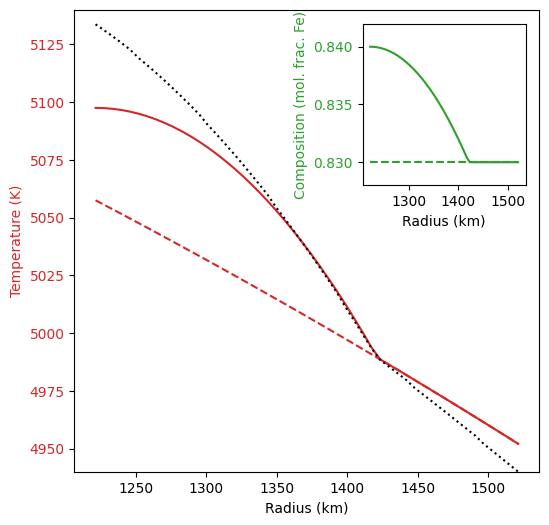

In [3]:
make_layer_plot(40, 0.01, 0.83)

## Case 2

This (25 K colder than the projected adiabat at the ICB and 1/16 mol % enriched in O) 
generates about 6 TW of heat and particles with a maximum radius of about 2 cm.

BV freq = 3.158504710825384e-05
Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Liquid density at ICB: 12765.469890753724 Kg/m^3
Liquid density at top of F-layer 12576.117662878722 Kg/m^3
Liquid density along adiabat at ICB: 12764.931169768386 Kg/m^3
Liquid density along adiabat at top of F-layer 12571.912798104033 Kg/m^3
Liquid density difference at ICB: 0.5387209853379318 Kg/m^3


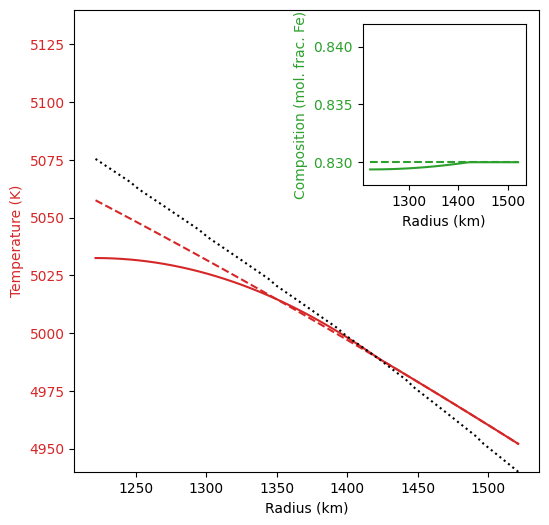

In [4]:
make_layer_plot(-25, -0.000625, 0.83)

## Case 3

This (25 K colder than the projected adiabat at the ICB and 1 mol % enriched in F) 
generates a massive 700 TW of heat and particles with a maximum radius of about 4 cm.


BV freq = 0.0002512627458156374
Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Temperature at CMB: 1565.182533320388 K
Liquid density at ICB: 12799.091281473222 Kg/m^3
Liquid density at top of F-layer 12534.180039787801 Kg/m^3
Liquid density along adiabat at ICB: 12764.931169768386 Kg/m^3
Liquid density along adiabat at top of F-layer 12571.912798104033 Kg/m^3
Liquid density difference at ICB: 34.1601117048358 Kg/m^3


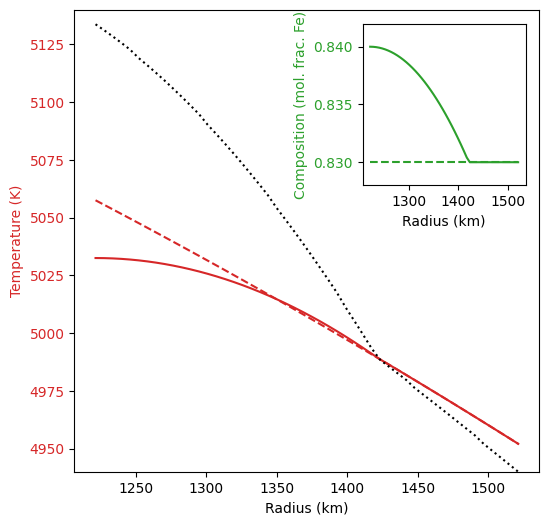

In [13]:
make_layer_plot(-25, 0.01, 0.83)

BV freq = 8.617261632145981e-05j
Pressure at ICB: 329.1010089948369 GPa
Pressure at top of F-layer 317.7026904318656 GPa
g at ICB: 4.403124222842614 m/s**2
g at top of F-layer 5.010242771751181 m/s**2
Temperature at CMB: 1565.182533320388 K
Liquid density at ICB: 12760.922305455506 Kg/m^3
Liquid density at top of F-layer 12582.033195338823 Kg/m^3
Liquid density along adiabat at ICB: 12764.931169768386 Kg/m^3
Liquid density along adiabat at top of F-layer 12571.912798104033 Kg/m^3
Liquid density difference at ICB: -4.008864312880178 Kg/m^3


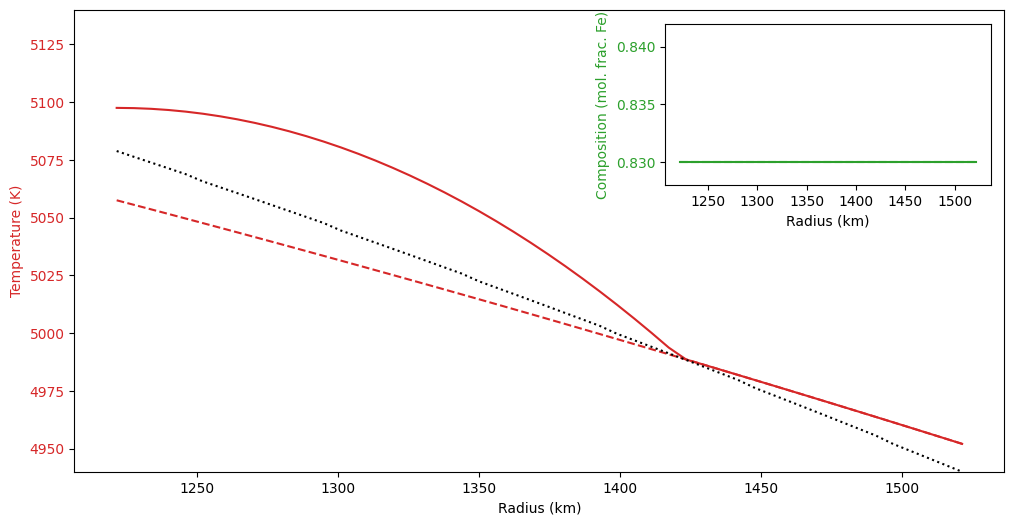

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
make_layer_plot(40, 0.0, 0.83, fig=fig, ax=ax)